In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
    return img, label

In [3]:
train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(8)
            .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(8)
        .prefetch(tf.data.AUTOTUNE)
)

In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model = keras.Sequential([
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.BatchNormalization(),       # Add BatchNorm
            keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
        ])

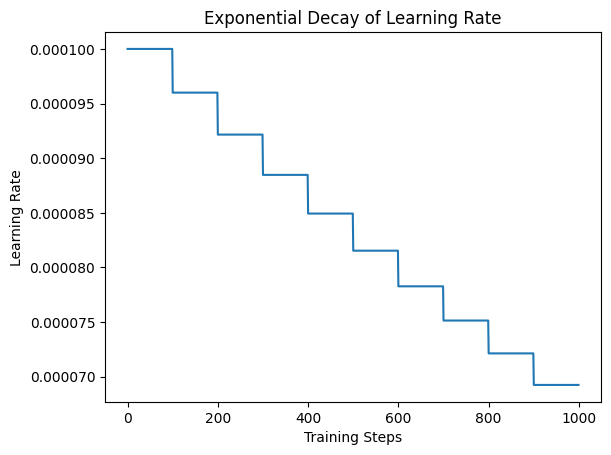

In [8]:
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

steps = np.arange(0, 1000)
lrs = [lr_schedule(step).numpy() for step in steps]

plt.plot(steps, lrs)
plt.title("Exponential Decay of Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.show()

In [11]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )


        # Visualize model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 2,232,837 (8.52 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [13]:
history = model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=5)

Epoch 1/5
    413/Unknown 276s 523ms/step - accuracy: 0.6424 - loss: 1.0064

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 312s 611ms/step - accuracy: 0.6426 - loss: 1.0058 - val_accuracy: 0.7676 - val_loss: 0.6878
Epoch 2/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 190s 381ms/step - accuracy: 0.9515 - loss: 0.1402 - val_accuracy: 0.8162 - val_loss: 0.6496
Epoch 3/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 127s 307ms/step - accuracy: 0.9962 - loss: 0.0256 - val_accuracy: 0.8568 - val_loss: 0.5037
Epoch 4/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 111s 267ms/step - accuracy: 0.9975 - loss: 0.0107 - val_accuracy: 0.8703 - val_loss: 0.4775
Epoch 5/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 100s 243ms/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 0.8730 - val_loss: 0.4567


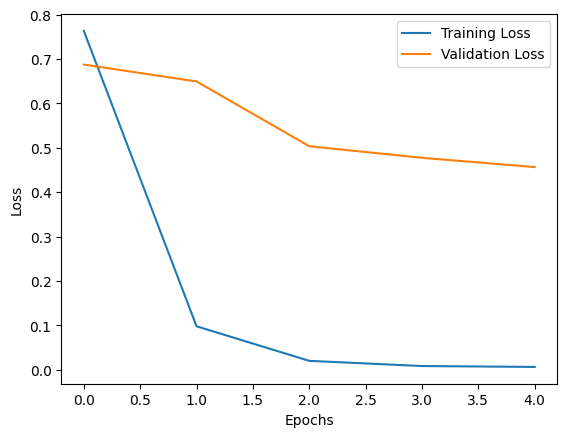

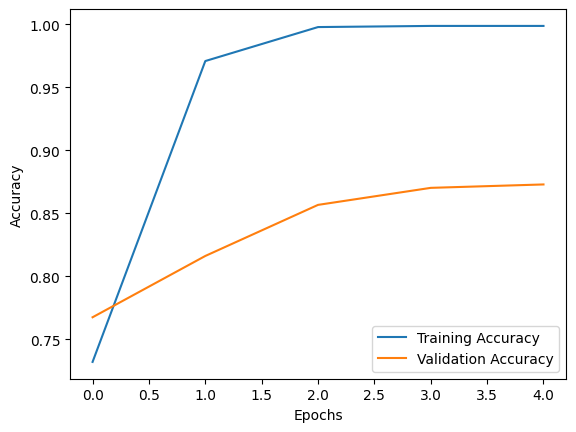

In [14]:
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"],label = "Training Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()